<a href="https://colab.research.google.com/github//vlamen/tue-deeplearning/blob/main/tutorials/P5.3_VAE_additional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Additional material on VAEs
Although the information in `P5.3_VAE.ipynb` is correct and useful, and manually implementing the reparameterization trick is good for educational purposes, modern Pytorch allows for easier and more flexible ways of implementing Variational Auto Encoders. We shall delve into this in this additional tutorial and also look at some useful tricks for training VAEs.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import distributions as D  # we'll use this for implementing our VAE easily
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

In [2]:
# get data
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

In [3]:
[tensor.shape for tensor in next(iter(train_loader))]

[torch.Size([100, 1, 28, 28]), torch.Size([100])]

The distributions in torch.distributions allow us to parameterize many commonly used probability distributions. For example, we can parameterize a normal distribution with mean `mu = torch.zeros(20, 10)` and *standard deviation* `sigma = torch.ones_like(mu)` as `normal_distribution = D.Normal(loc=mu, scale=sigma)`.
These objects already implement the reparameterization trick for us as `rsample` and the log-likelihood function as `log_prob`. 

This allows us to write a VAE in a high level way as follows:

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_size:int, encoder:nn.Module, decoder:nn.Module):
        """
        :param latent_size: dimension of the latent space
        :param encoder: an nn.Module that takes in data, x, and returns a D.Distribution instance representing q(z|x)
        :param decoder: an nn.Module that takes in latent codes, z, and returns a D.Distributino instance representing p(x|z)
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_size = latent_size

        self._init_prior()
         
    def _init_prior(self):
        # for simplicity, let's stick with a standard normal distribution as a prior
        self.register_buffer('prior_loc', torch.zeros(self.latent_size))
        self.register_buffer('prior_scale', torch.ones(self.latent_size))
        # using buffers makes sure that these are moved to the same device the rest of the network is on
        # if we'd want the location and scale of the prior to be learned, we could use nn.Parameter instead of buffers, 
        # although we would have to make sure the scale is always positive
        # alternatively we could add a prior:nn.Module argument to the __init__ for even more freedom

    @property
    def prior(self)->D.Distribution:
        return D.Normal(loc=self.prior_loc, scale=self.prior_scale)

    def forward(self, x: torch.Tensor) -> tuple[D.Distribution, D.Distribution, torch.Tensor]:
        """ 
        To keep the forward pass of our model somewhat similar to the VAE class in `P5.3_VAE.ipynb`, we return the decoding distribution, encoding distribution and latent code
        
        :param x: batch of data
        :return: p(x|z), q(z|x), z
        """
        encoding_distribution = self.encoder(x)  # q(z|x)
        z = encoding_distribution.rsample()  # NB use rsample for reparameterization trick
        decoding_distribution = self.decoder(z)  # p(x|z)

        return decoding_distribution, encoding_distribution, z # p(x|z), q(z|x), z

    def compute_losses(self, x, decoding_distribution, encoding_distribution, z) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the Kullback Leibler Divergence and the reconstruction loss
        :param x: batch of data
        :param decoding_distribution: p(x|z)
        :param encoding_distribution: q(z|x)
        :param z: sample from q(z|x) used for p(x|z)
        :return: reconstruction_loss, dkl
        """

        dkl = encoding_distribution.log_prob(z).mean(0).sum() - self.prior.log_prob(z).mean(0).sum()  # mean over batch, sum over everything else
        # here we don't make use of the analytic expression of the dkl between two gaussians
        # instead we use the generic Stochastic Gradient Variational Bayes estimator \tilde{\mathcal{L}}^A from the Auto-Encoding Variational Bayes paper
        # the drawback of this is that this only gives an approximation of the dkl
        # the advantage is that it is much more flexible: 
        #     we are not assuming the encoding distribution is a normal distribution with diagonal covariance matrix
        #     and if we want to use a different prior, this would require minimal code changes

        reconstruction_loss = -decoding_distribution.log_prob(x).mean(0).sum()  # mean over batch, sum over everything else

        return reconstruction_loss, dkl
    
    def encode(self, x: torch.Tensor)->torch.Tensor:
        """encode method for encoding data

        :param x: batch of datapoints
        :return: latent representations of said batch
        """
        encoding_distribution: D.Distribution = self.encoder(x)
        return encoding_distribution.rsample() 
    
    def sample(self, num_samples:int, take_mean:bool=True) -> Union[torch.Tensor, D.Distribution]:
        z = self.prior.sample((num_samples,))
        decoding_distribution: D.Normal = self.decoder(z)

        if take_mean:
            # often instead of sampling from the decoding distribution, we just want to take its mean
            # note that under the assumption that the decoding distribution is normal, sampling from it 
            # would correspond to taking the mean and adding Gaussian noise to that mean
            return decoding_distribution.loc  
        return decoding_distribution.sample()
    
    def auto_encode(self, x:torch.Tensor, take_mean:bool=True)->Union[torch.Tensor, D.Distribution]:
        decoding_distribution, _, _ = self(x)
        if take_mean:
            return decoding_distribution.loc 
        return decoding_distribution.sample()
        

Let's now see what changes we need to make to the encoder and decoder code from before.

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_pre_scale = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)  # we'll do the flattening in the encoder model instead of in the training loop
        # this makes it easier to swap out the Encoder for e.g. a convolutional architecture if we want to do so
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        pre_scale = self.fc_pre_scale(h)
        scale = F.softplus(pre_scale)
        # the scale of the distribution needs to be positive
        # one way to accomplish this, as shown in the previous tutorial, is to parameterize the logarithm of the scale (log_sigma)
        # this was useful because we needed log_sigma for the analytical expression for the Dkl
        # however, to get the scale, we then need to take the exponential of log_sigma, which can blow up quite rapidly
        # using a softplus activation instead can be numerically more stable since it is (approximately) linear for large inputs

        encoding_distribution = D.Normal(loc=mu, scale=scale)
        # note that to use a different family of distributions for the encoder, we wouldn't need to change anything about the VAE class or the loss function
        return encoding_distribution
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_shape=(1, 28, 28), scale=1/np.sqrt(2)):
        """ 
        :param latent_dim: dimensionality of the latent space
        :param hidden_dim: size of hidden layers
        :param output_shape: shape that the output should have (excluding batch dimension) 
        :param scale: scale of the output distribution. 
            as explained in the previous notebook, because we're using a normal distribution,
            this is essentially a factor for the mean squared error. 
        """
        super(Decoder, self).__init__()

        self.output_shape = tuple(output_shape)
        output_dim = np.prod(output_shape)

        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
        self.register_buffer('scale', torch.as_tensor(scale, dtype=torch.float32))
        
    def forward(self, z):
        batch_size = z.shape[0]
        h = torch.relu(self.fc_hidden1(z))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h)).view(
            (batch_size,)+self.output_shape
            )
        
        return D.Normal(loc=x_reconstr, scale=self.scale)
    

In [6]:
x_dim  = 784
hidden_dim = 500
latent_dim = 12

vae = VAE(
    latent_dim,
    Encoder(x_dim, hidden_dim, latent_dim),
    Decoder(latent_dim, hidden_dim, (1, 28, 28))
)

In [7]:
lr = 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

epochs = 50
vae.train()

n_batches = len(train_loader)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')

vae.to(device=device)

print("Start training")
for epoch in range(1, epochs+1):
    total_loss = 0
    total_rec = 0
    total_dkl = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        rec, dkl = vae.compute_losses(batch, *vae(batch))

        loss = rec + dkl 
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_dkl += dkl.item()
        total_rec += rec.item()
    avg_loss = total_loss / n_batches
    avg_dkl = total_dkl / n_batches 
    avg_rec = total_rec / n_batches
    print(f"Finished epoch {epoch} / {epochs}.\t Average loss: {avg_loss:.4f}\t Average reconstruction loss: {avg_rec:.4f}\t Average Dkl: {avg_dkl:.4f}")
print("Finished training")
vae.to(cpu)

del batch 


Start training
Finished epoch 1 / 50.	 Average loss: 493.3871	 Average reconstruction loss: 489.2414	 Average Dkl: 4.1457
Finished epoch 2 / 50.	 Average loss: 482.5598	 Average reconstruction loss: 474.8811	 Average Dkl: 7.6787
Finished epoch 3 / 50.	 Average loss: 480.6851	 Average reconstruction loss: 472.3500	 Average Dkl: 8.3351
Finished epoch 4 / 50.	 Average loss: 479.7457	 Average reconstruction loss: 471.0952	 Average Dkl: 8.6505
Finished epoch 5 / 50.	 Average loss: 479.1158	 Average reconstruction loss: 470.2543	 Average Dkl: 8.8615
Finished epoch 6 / 50.	 Average loss: 478.6883	 Average reconstruction loss: 469.6589	 Average Dkl: 9.0295
Finished epoch 7 / 50.	 Average loss: 478.3350	 Average reconstruction loss: 469.1859	 Average Dkl: 9.1491
Finished epoch 8 / 50.	 Average loss: 478.0602	 Average reconstruction loss: 468.8039	 Average Dkl: 9.2564
Finished epoch 9 / 50.	 Average loss: 477.8367	 Average reconstruction loss: 468.4952	 Average Dkl: 9.3415
Finished epoch 10 / 50

# About the reconstruction loss
In light of the previous tutorial, our reconstruction loss seems rather high. Why is this?
Well, remember that for the loss function in `P5.3_VAE.ipynb`, we didn't use the actual log-likelihood of the decoding distribution, but only used the non-constant part.
Our reconstruction loss here is the mean squared error *plus* this constant, which is $\frac{28*28}{2} \cdot (\log(2\pi) + \log(1/2)) \approx 448.7341$.
We can check this: 

In [8]:
vae.eval()
batch, _ = next(iter(train_loader))
dec_dist = vae(batch)[0]
reconstruction = dec_dist.loc 

(-dec_dist.log_prob(batch).mean(0).sum()) - torch.square(reconstruction - batch).mean(0).sum()

tensor(448.7341, grad_fn=<SubBackward0>)

In [9]:
torch.square(reconstruction - batch).mean(0).sum()

tensor(17.8219, grad_fn=<SumBackward0>)

Let's look at the reconstructions and samples from the model and investigate the latent space

In [10]:
originals = []
reconstructions = []
codes = []
labels = []

vae.eval()
vae.to(device=device)
with torch.no_grad():
    for batch, y in test_loader:
        originals.append(batch.detach())
        labels.append(y)
        batch = batch.to(device)
        dec, enc, _ = vae(batch)
        
        reconstructions.append(dec.loc.detach().cpu())
        codes.append(enc.loc.detach().cpu())
vae.to(device=cpu)
        

VAE(
  (encoder): Encoder(
    (fc_input): Linear(in_features=784, out_features=500, bias=True)
    (fc_hidden): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=12, bias=True)
    (fc_pre_scale): Linear(in_features=500, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc_hidden1): Linear(in_features=12, out_features=500, bias=True)
    (fc_hidden2): Linear(in_features=500, out_features=500, bias=True)
    (fc_output): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [11]:
def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, 28, 28)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')



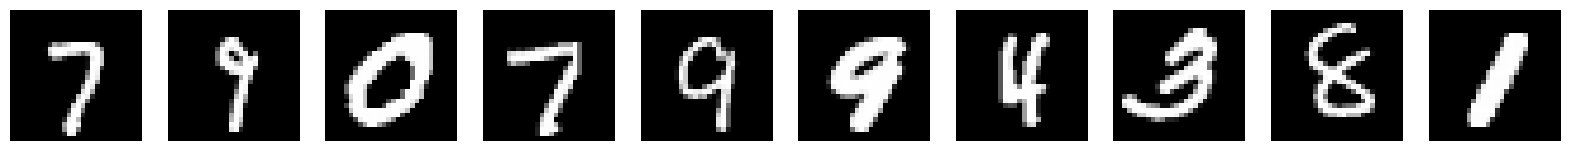

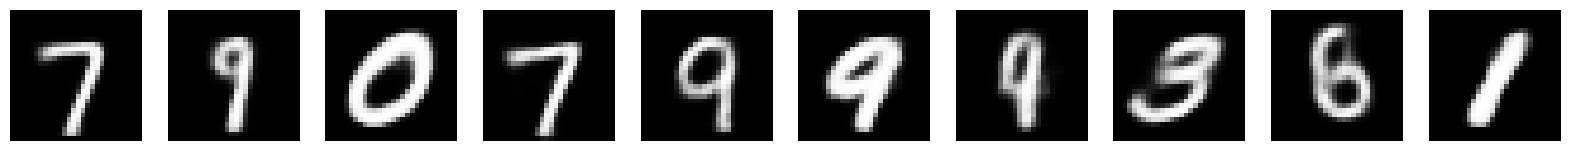

In [12]:
batch_idx = 0
show_images(originals[batch_idx])
show_images(reconstructions[batch_idx])

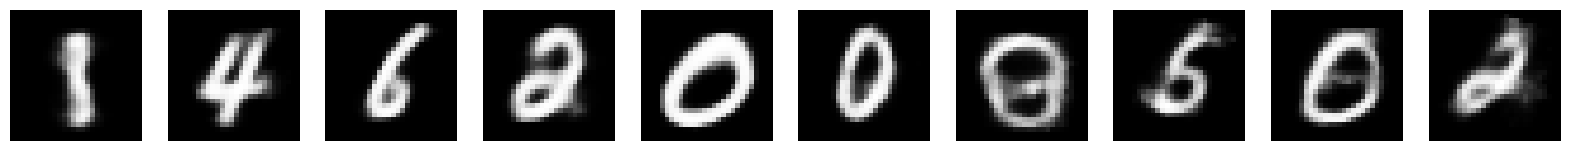

In [13]:
with torch.no_grad():
    show_images(vae.sample(10))

Because we have a latent space that is higher than two dimensional, we can't just plot the latent codes directly. However, using a tSNE embedding, we can still get an impression of what the latent space looks like:

In [14]:
from sklearn.manifold import TSNE
with torch.no_grad():
    all_codes = torch.cat(codes, 0).numpy()
    labels = torch.cat(labels, 0).numpy()

all_codes_embedded = TSNE(n_components=2).fit_transform(all_codes)

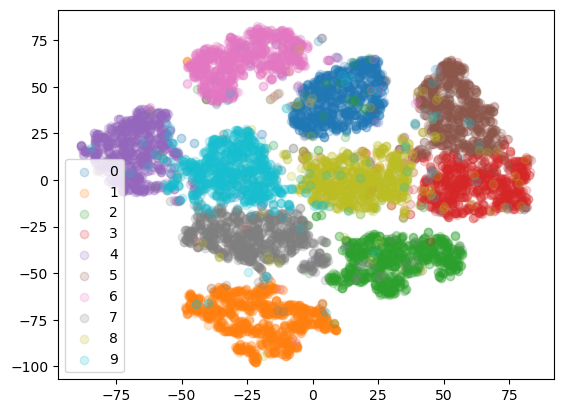

In [15]:
for label in range(10):
    embedded_codes_for_label = all_codes_embedded[labels==label]
    plt.scatter(embedded_codes_for_label[:, 0], embedded_codes_for_label[:, 1], alpha=.2, label=label)
plt.legend()
plt.show()

As we can see, it looks like the VAE has done a decent job at clustering the different codes for the same class in the dataset together. With MNIST this is rather easy to do, but for even slightly more complicated datasets our latent space might not look as nice. 

Extensive research has been done on the question of how to get a nicer latent space by various standards. One very simple trick that can be of use, is to vary the weight of the Dkl term in the total loss cyclically over the training process. This is especially useful when using a very strong, auto-regressive, decoding distribution. Admittedly, that is not the case for the architecture we are using, but let's nonetheless look at how this works.

Paper about cyclical KL annealing: https://arxiv.org/pdf/1903.10145.pdf

Paper about adding a weight to the KL divergence: https://openreview.net/pdf?id=Sy2fzU9gl


In [16]:

class CyclicKLScheduler:
    def __init__(self, period:int, maxval:float=1.0, minval:float=0., plateau_length:int=0):
        self.period = period
        self.maxval = maxval
        self._index = 0
        period = period-plateau_length

        self._values = np.concatenate([np.linspace(minval, maxval, period), np.full((plateau_length,), maxval)], 0)

    def step(self):
        self._index = (self._index + 1) % self.period

    @property
    def val(self):
        return self._values[self._index]

beta = 2.
epoch_period = 10 
epochs = 5 * epoch_period
period = epoch_period * n_batches
plateau_length = n_batches


Start training
Finished epoch 1 / 50.
Average loss: 491.1274	 Average reconstruction loss: 490.4226	 Average Dkl: 6.9919
Start evaluation loop
Eval beta-vae loss: 495.9328	 Eval reconstruction loss: 484.0413	 Eval Dkl: 5.9457

Finished epoch 2 / 50.
Average loss: 484.6181	 Average reconstruction loss: 482.6854	 Average Dkl: 5.8323
Start evaluation loop
Eval beta-vae loss: 492.6067	 Eval reconstruction loss: 481.7177	 Eval Dkl: 5.4445

Finished epoch 3 / 50.
Average loss: 484.2648	 Average reconstruction loss: 481.2822	 Average Dkl: 5.3808
Start evaluation loop
Eval beta-vae loss: 491.2904	 Eval reconstruction loss: 481.1489	 Eval Dkl: 5.0708

Finished epoch 4 / 50.
Average loss: 484.6077	 Average reconstruction loss: 480.6385	 Average Dkl: 5.1105
Start evaluation loop
Eval beta-vae loss: 490.5829	 Eval reconstruction loss: 480.4428	 Eval Dkl: 5.0700

Finished epoch 5 / 50.
Average loss: 485.2699	 Average reconstruction loss: 480.3816	 Average Dkl: 4.8919
Start evaluation loop
Eval beta

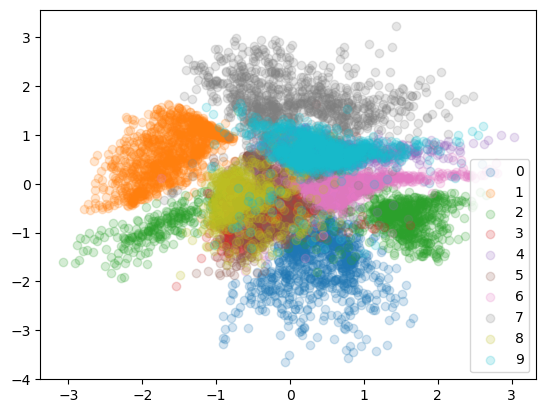


Finished epoch 11 / 50.
Average loss: 478.6067	 Average reconstruction loss: 477.7844	 Average Dkl: 7.7101
Start evaluation loop
Eval beta-vae loss: 491.6152	 Eval reconstruction loss: 477.9087	 Eval Dkl: 6.8532

Finished epoch 12 / 50.
Average loss: 479.8603	 Average reconstruction loss: 477.7028	 Average Dkl: 6.5142
Start evaluation loop
Eval beta-vae loss: 490.3467	 Eval reconstruction loss: 477.9288	 Eval Dkl: 6.2090

Finished epoch 13 / 50.
Average loss: 481.0760	 Average reconstruction loss: 477.7544	 Average Dkl: 5.9931
Start evaluation loop
Eval beta-vae loss: 489.4952	 Eval reconstruction loss: 478.0304	 Eval Dkl: 5.7324

Finished epoch 14 / 50.
Average loss: 482.2734	 Average reconstruction loss: 477.8898	 Average Dkl: 5.6441
Start evaluation loop
Eval beta-vae loss: 489.0408	 Eval reconstruction loss: 478.3217	 Eval Dkl: 5.3596

Finished epoch 15 / 50.
Average loss: 483.4118	 Average reconstruction loss: 478.0435	 Average Dkl: 5.3730
Start evaluation loop
Eval beta-vae loss

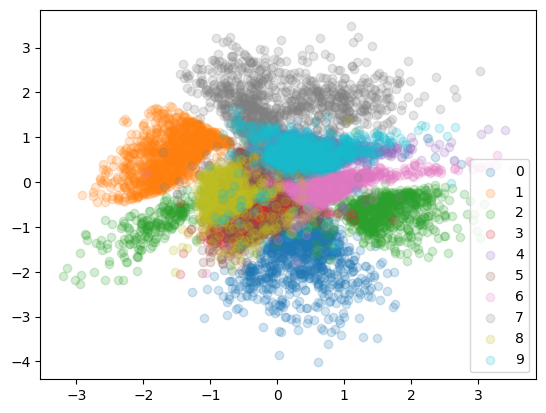


Finished epoch 21 / 50.
Average loss: 477.3478	 Average reconstruction loss: 476.4974	 Average Dkl: 7.8786
Start evaluation loop
Eval beta-vae loss: 491.1216	 Eval reconstruction loss: 476.8170	 Eval Dkl: 7.1523

Finished epoch 22 / 50.
Average loss: 478.7258	 Average reconstruction loss: 476.4849	 Average Dkl: 6.7665
Start evaluation loop
Eval beta-vae loss: 490.0481	 Eval reconstruction loss: 477.1018	 Eval Dkl: 6.4731

Finished epoch 23 / 50.
Average loss: 480.1635	 Average reconstruction loss: 476.7153	 Average Dkl: 6.2230
Start evaluation loop
Eval beta-vae loss: 489.2697	 Eval reconstruction loss: 477.3458	 Eval Dkl: 5.9620

Finished epoch 24 / 50.
Average loss: 481.4590	 Average reconstruction loss: 476.9180	 Average Dkl: 5.8465
Start evaluation loop
Eval beta-vae loss: 488.8186	 Eval reconstruction loss: 477.3991	 Eval Dkl: 5.7097

Finished epoch 25 / 50.
Average loss: 482.7100	 Average reconstruction loss: 477.1510	 Average Dkl: 5.5647
Start evaluation loop
Eval beta-vae loss

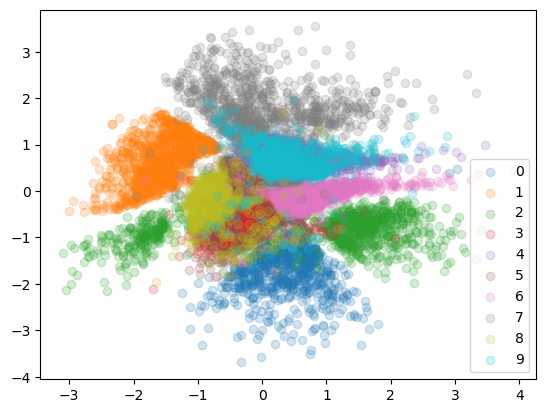


Finished epoch 31 / 50.
Average loss: 476.7661	 Average reconstruction loss: 475.9048	 Average Dkl: 7.9585
Start evaluation loop
Eval beta-vae loss: 491.0172	 Eval reconstruction loss: 476.4746	 Eval Dkl: 7.2713

Finished epoch 32 / 50.
Average loss: 478.2236	 Average reconstruction loss: 475.9405	 Average Dkl: 6.8926
Start evaluation loop
Eval beta-vae loss: 489.7147	 Eval reconstruction loss: 476.7323	 Eval Dkl: 6.4912

Finished epoch 33 / 50.
Average loss: 479.6581	 Average reconstruction loss: 476.1480	 Average Dkl: 6.3334
Start evaluation loop
Eval beta-vae loss: 489.3458	 Eval reconstruction loss: 477.0022	 Eval Dkl: 6.1718

Finished epoch 34 / 50.
Average loss: 481.0219	 Average reconstruction loss: 476.3833	 Average Dkl: 5.9714
Start evaluation loop
Eval beta-vae loss: 488.6260	 Eval reconstruction loss: 477.1025	 Eval Dkl: 5.7617

Finished epoch 35 / 50.
Average loss: 482.2989	 Average reconstruction loss: 476.6276	 Average Dkl: 5.6756
Start evaluation loop
Eval beta-vae loss

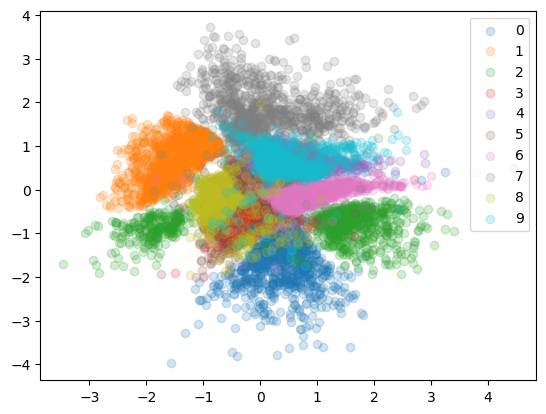


Finished epoch 41 / 50.
Average loss: 476.3097	 Average reconstruction loss: 475.4356	 Average Dkl: 8.0426
Start evaluation loop
Eval beta-vae loss: 490.7992	 Eval reconstruction loss: 476.1307	 Eval Dkl: 7.3343

Finished epoch 42 / 50.
Average loss: 477.8635	 Average reconstruction loss: 475.5606	 Average Dkl: 6.9536
Start evaluation loop
Eval beta-vae loss: 489.6396	 Eval reconstruction loss: 476.5343	 Eval Dkl: 6.5526

Finished epoch 43 / 50.
Average loss: 479.3209	 Average reconstruction loss: 475.7709	 Average Dkl: 6.4052
Start evaluation loop
Eval beta-vae loss: 489.0510	 Eval reconstruction loss: 476.6428	 Eval Dkl: 6.2041

Finished epoch 44 / 50.
Average loss: 480.6843	 Average reconstruction loss: 476.0073	 Average Dkl: 6.0227
Start evaluation loop
Eval beta-vae loss: 488.6739	 Eval reconstruction loss: 476.9976	 Eval Dkl: 5.8381

Finished epoch 45 / 50.
Average loss: 482.0587	 Average reconstruction loss: 476.3335	 Average Dkl: 5.7299
Start evaluation loop
Eval beta-vae loss

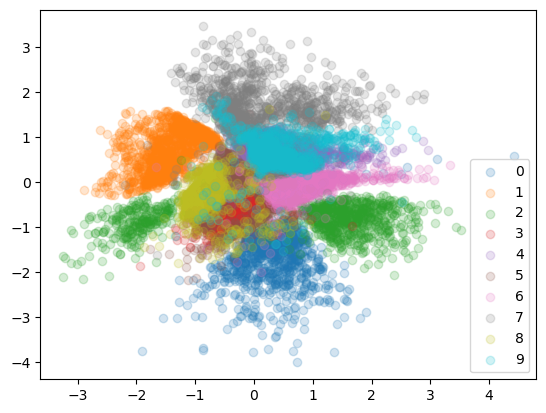


Finished training


VAE(
  (encoder): Encoder(
    (fc_input): Linear(in_features=784, out_features=500, bias=True)
    (fc_hidden): Linear(in_features=500, out_features=500, bias=True)
    (fc_mu): Linear(in_features=500, out_features=2, bias=True)
    (fc_pre_scale): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_hidden1): Linear(in_features=2, out_features=500, bias=True)
    (fc_hidden2): Linear(in_features=500, out_features=500, bias=True)
    (fc_output): Linear(in_features=500, out_features=784, bias=True)
  )
)

In [17]:
latent_dim = 2

beta_vae = VAE(
    latent_dim,
    Encoder(x_dim, hidden_dim, latent_dim),
    Decoder(latent_dim, hidden_dim, (1, 28, 28))
)

beta_vae.to(device=device)

beta_optimizer = torch.optim.Adam(beta_vae.parameters(), lr=lr)
kl_scheduler = CyclicKLScheduler(period=period, maxval=beta, plateau_length=n_batches)


print("Start training")
for epoch in range(1, epochs+1):
    beta_vae.train()
    total_loss = 0
    total_rec = 0
    total_dkl = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        beta_optimizer.zero_grad()

        rec, dkl = beta_vae.compute_losses(batch, *beta_vae(batch))

        loss = rec + kl_scheduler.val * dkl 
        loss.backward()

        beta_optimizer.step()
        kl_scheduler.step()

        total_loss += loss.item()
        total_dkl += dkl.item()
        total_rec += rec.item()
    avg_loss = total_loss / n_batches
    avg_dkl = total_dkl / n_batches 
    avg_rec = total_rec / n_batches
    print(f"Finished epoch {epoch} / {epochs}.\nAverage loss: {avg_loss:.4f}\t Average reconstruction loss: {avg_rec:.4f}\t Average Dkl: {avg_dkl:.4f}")
    print(f"Start evaluation loop")

    beta_vae.eval()
    with torch.no_grad():
        all_mu = []
        all_labels = []
        total_rec = 0
        total_dkl = 0
        for batch, y in test_loader:
            batch = batch.to(device)
            all_labels.append(y)

            dec, enc, z = beta_vae(batch)
            rec, dkl = beta_vae.compute_losses(batch, dec, enc, z)
            all_mu.append(enc.loc.detach().cpu())
            total_rec += rec.item()
            total_dkl += dkl.item()

        avg_rec = total_rec / len(test_loader)
        avg_dkl = total_dkl / len(test_loader)
        avg_loss = avg_rec + kl_scheduler.maxval * avg_dkl
        print(f"Eval beta-vae loss: {avg_loss:.4f}\t Eval reconstruction loss: {avg_rec:.4f}\t Eval Dkl: {avg_dkl:.4f}")
        if epoch % epoch_period == 0:
            all_mu = torch.cat(all_mu, 0).numpy()
            all_labels = torch.cat(all_labels, 0).numpy()
            
            for label in range(10):
                mu_for_label = all_mu[all_labels==label]
                plt.scatter(mu_for_label[:, 0], mu_for_label[:, 1], alpha=.2, label=label)
            plt.legend()
            plt.show()
            del all_mu, all_labels, mu_for_label
        print("")

print("Finished training")
beta_vae.to(cpu)


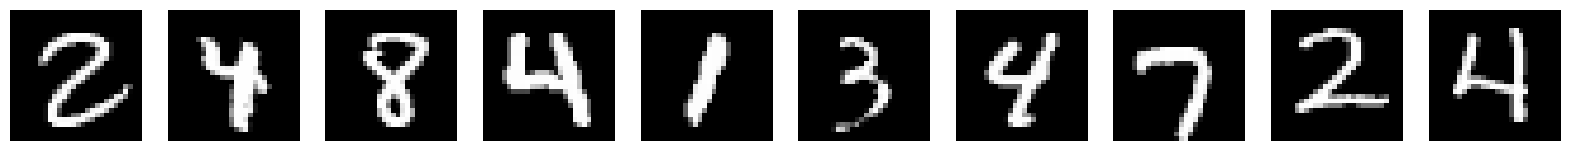

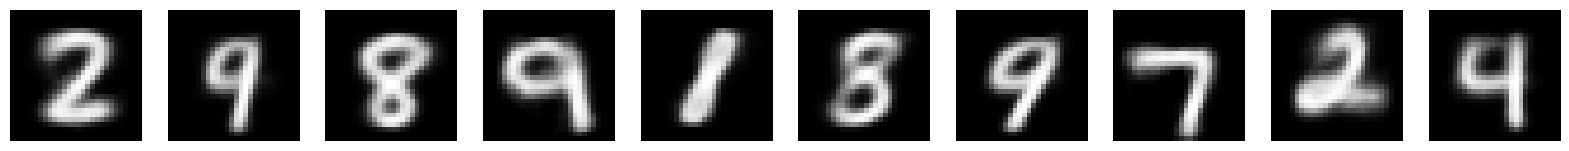

In [18]:
with torch.no_grad():
    batch, _ = next(iter(test_loader))
    reconstructions = beta_vae.auto_encode(batch)
    show_images(batch)
    show_images(reconstructions)

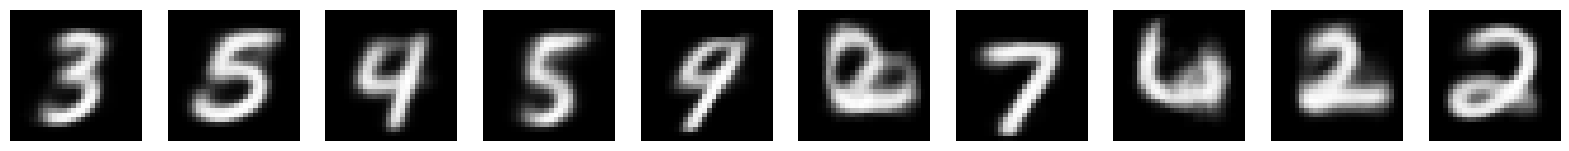

In [19]:
with torch.no_grad():
    show_images(beta_vae.sample(10))